<a href="https://colab.research.google.com/github/0jin03/5th-Static-Competition/blob/main/%EC%88%98%EC%9B%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the dataset from the URL
url = "https://github.com/0jin03/0jin03/blob/main/Suwon.xlsx?raw=true"
df = pd.read_excel(url, engine='openpyxl')

# Select the features and the target variable
features = ['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
            'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike',
            'feelslikemax']

target = 'Predicted_Health_Risk_Score'

# Drop any rows with missing values for simplicity
df = df.dropna()

# Split the data into features and target
X = df[features]
y = df[target]

# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape the input for LSTM/GRU (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Function to create and compile LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to create and compile GRU model
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and train the LSTM model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# Create and train the GRU model
gru_model = create_gru_model((X_train.shape[1], X_train.shape[2]))
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# Predict using the trained models
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru)
y_test = scaler_y.inverse_transform(y_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# LSTM Metrics
lstm_metrics = calculate_metrics(y_test, y_pred_lstm)

# GRU Metrics
gru_metrics = calculate_metrics(y_test, y_pred_gru)

# Display the metrics
import pandas as pd
metrics_df = pd.DataFrame({
    "Model": ["LSTM", "GRU"],
    "MAE": [lstm_metrics[0], gru_metrics[0]],
    "MSE": [lstm_metrics[1], gru_metrics[1]],
    "RMSE": [lstm_metrics[2], gru_metrics[2]],
    "R2": [lstm_metrics[3], gru_metrics[3]]
})

print(metrics_df)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
  Model       MAE       MSE      RMSE        R2
0  LSTM  0.205661  0.072309  0.268903  0.762458
1   GRU  0.208707  0.076917  0.277338  0.747321


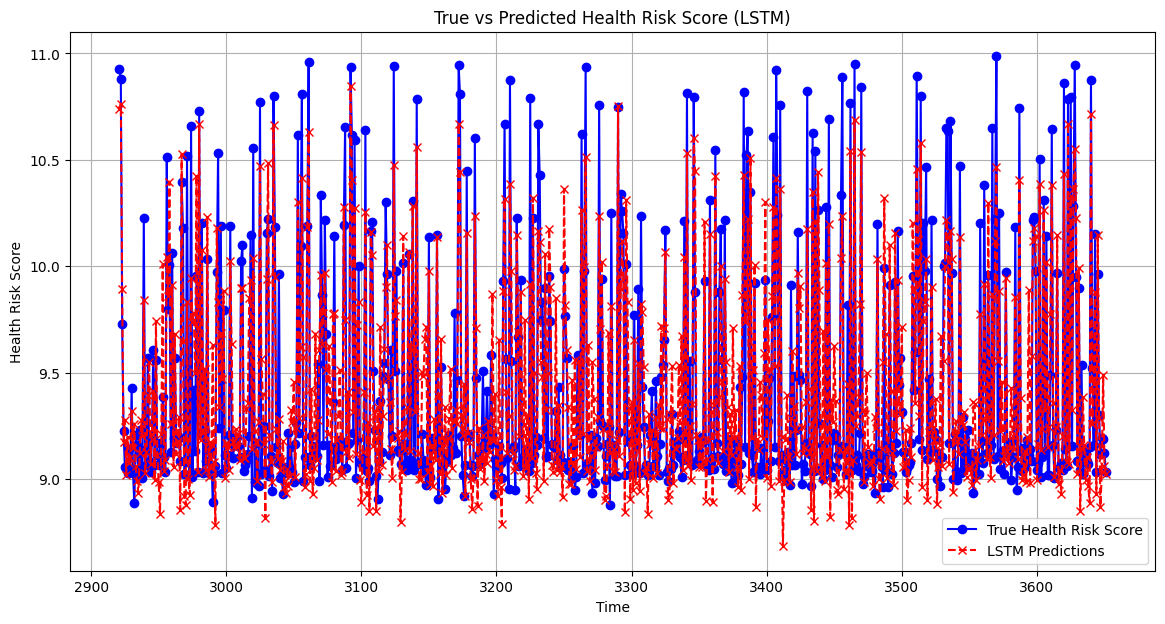

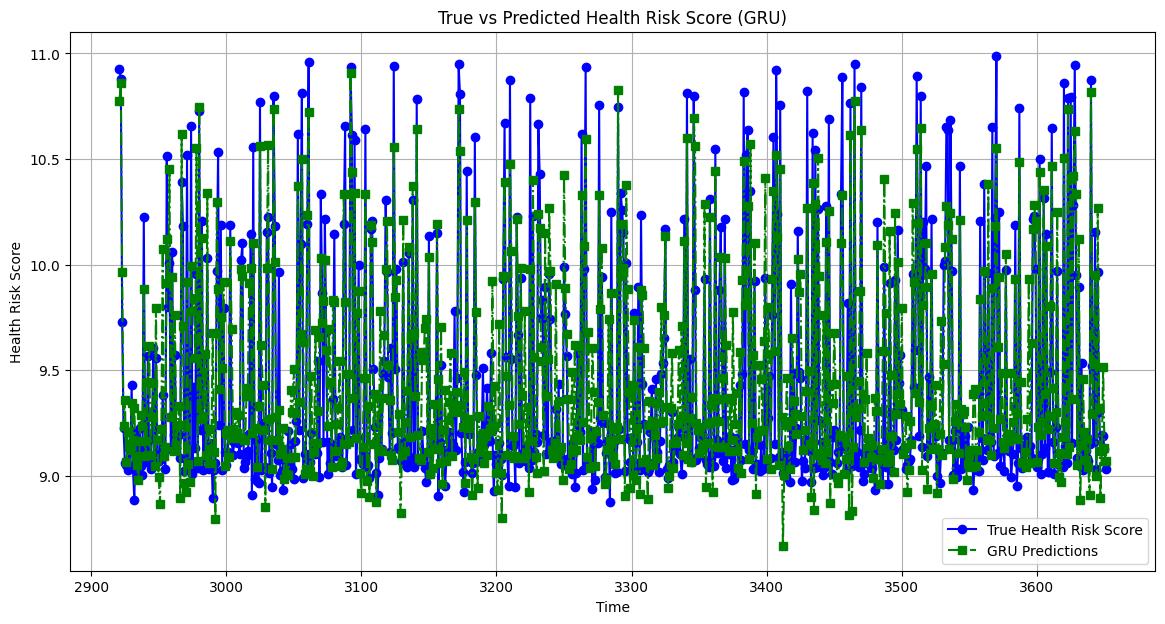

In [12]:
# Plotting the LSTM predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Health Risk Score', color='blue', linestyle='-', marker='o')
plt.plot(df.index[-len(y_test):], y_pred_lstm, label='LSTM Predictions', color='red', linestyle='--', marker='x')
plt.title('True vs Predicted Health Risk Score (LSTM)')
plt.xlabel('Time')
plt.ylabel('Health Risk Score')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the GRU predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Health Risk Score', color='blue', linestyle='-', marker='o')
plt.plot(df.index[-len(y_test):], y_pred_gru, label='GRU Predictions', color='green', linestyle='-.', marker='s')
plt.title('True vs Predicted Health Risk Score (GRU)')
plt.xlabel('Time')
plt.ylabel('Health Risk Score')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


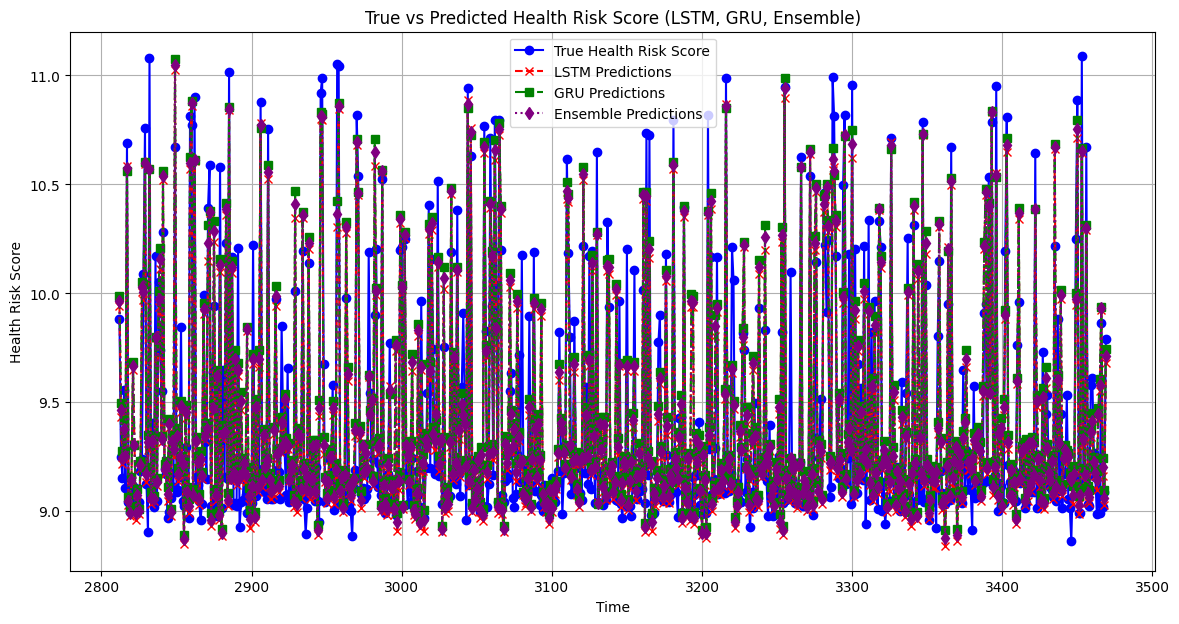

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# 데이터 로드
url = "https://github.com/0jin03/0jin03/blob/main/Suwon.xlsx?raw=true"
df = pd.read_excel(url, engine='openpyxl')

# 계절성 및 트렌드 분리
decomposition = seasonal_decompose(df['Predicted_Health_Risk_Score'], model='multiplicative', period=365)
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()

# 트렌드와 계절성을 특성으로 추가
df['trend'] = trend
df['seasonal'] = seasonal

# 누락된 값 제거
df = df.dropna()

# 특징 및 타겟 설정
features = ['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
            'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike',
            'feelslikemax', 'trend', 'seasonal']

target = 'Predicted_Health_Risk_Score'

X = df[features]
y = df[target]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# LSTM/GRU 입력 형태로 변환 (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# 훈련 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# LSTM 모델 생성 및 학습
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# GRU 모델 생성 및 학습
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

gru_model = create_gru_model((X_train.shape[1], X_train.shape[2]))
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# 예측 수행
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)

# LSTM과 GRU 앙상블 예측 (가중 평균)
ensemble_pred = (y_pred_lstm + y_pred_gru) / 2

# 스케일링 원래대로 복원
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru)
ensemble_pred = scaler_y.inverse_transform(ensemble_pred)
y_test = scaler_y.inverse_transform(y_test)

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Health Risk Score', color='blue', linestyle='-', marker='o')
plt.plot(df.index[-len(y_test):], y_pred_lstm, label='LSTM Predictions', color='red', linestyle='--', marker='x')
plt.plot(df.index[-len(y_test):], y_pred_gru, label='GRU Predictions', color='green', linestyle='-.', marker='s')
plt.plot(df.index[-len(y_test):], ensemble_pred, label='Ensemble Predictions', color='purple', linestyle=':', marker='d')
plt.title('True vs Predicted Health Risk Score (LSTM, GRU, Ensemble)')
plt.xlabel('Time')
plt.ylabel('Health Risk Score')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# LSTM Metrics
lstm_metrics = calculate_metrics(y_test, y_pred_lstm)

# GRU Metrics
gru_metrics = calculate_metrics(y_test, y_pred_gru)

# Ensemble Metrics
ensemble_metrics = calculate_metrics(y_test, ensemble_pred)

# Display the metrics
import pandas as pd
metrics_df = pd.DataFrame({
    "Model": ["LSTM", "GRU","ENSEMBLE"],
    "MAE": [lstm_metrics[0], gru_metrics[0],ensemble_metrics[0]],
    "MSE": [lstm_metrics[1], gru_metrics[1],ensemble_metrics[1]],
    "RMSE": [lstm_metrics[2], gru_metrics[2],ensemble_metrics[2]],
    "R2": [lstm_metrics[3], gru_metrics[3],ensemble_metrics[3]]
})

print(metrics_df)

      Model       MAE       MSE      RMSE        R2
0      LSTM  0.162946  0.055645  0.235892  0.811903
1       GRU  0.175397  0.061623  0.248239  0.791697
2  ENSEMBLE  0.167266  0.057855  0.240530  0.804434


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the dataset from the URL
url = "https://github.com/0jin03/0jin03/blob/main/Suwon.xlsx?raw=true"
df = pd.read_excel(url, engine='openpyxl')

# Select the features and the target variable
features = ['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
            'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike',
            'feelslikemax']

target = 'Predicted_Health_Risk_Score'

# Drop any rows with missing values for simplicity
df = df.dropna()

# Split the data into features and target
X = df[features]
y = df[target]

# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape the input for LSTM/GRU (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 준비 및 전처리 (X, y는 이전 코드에서 준비한 데이터라고 가정)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 하이퍼파라미터 튜닝을 위한 설정
units_options = [50, 100, 150]
dropout_rate_options = [0.2, 0.3, 0.4]
best_mse = float('inf')
best_r2 = -float('inf')
best_params = {}

for units in units_options:
    for dropout_rate in dropout_rate_options:
        # 모델 생성
        model = Sequential()
        model.add(LSTM(units=units, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # 모델 학습
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

        # 예측 수행
        y_pred = model.predict(X_test)

        # 성능 평가
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Units: {units}, Dropout Rate: {dropout_rate}, MSE: {mse}, R-squared: {r2}")

        # 최적의 파라미터를 업데이트
        if mse < best_mse:
            best_mse = mse
            best_r2 = r2
            best_params = {'units': units, 'dropout_rate': dropout_rate}

print(f"Best Params: {best_params}, Best MSE: {best_mse}, Best R-squared: {best_r2}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Units: 50, Dropout Rate: 0.2, MSE: 0.01531990315871285, R-squared: 0.7412726883761918


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Units: 50, Dropout Rate: 0.3, MSE: 0.01583189624555501, R-squared: 0.7326259891408047


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Units: 50, Dropout Rate: 0.4, MSE: 0.016472175828044833, R-squared: 0.7218127474806579


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Units: 100, Dropout Rate: 0.2, MSE: 0.015040698285633439, R-squared: 0.745987987517167


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Units: 100, Dropout Rate: 0.3, MSE: 0.015221880550184246, R-squared: 0.7429281248185908


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Units: 100, Dropout Rate: 0.4, MSE: 0.01575031331906923, R-squared: 0.7340037870958827


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Units: 150, Dropout Rate: 0.2, MSE: 0.014636705967424488, R-squared: 0.7528107360243876


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Units: 150, Dropout Rate: 0.3, MSE: 0.01555416251330045, R-squared: 0.7373164431958358


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Units: 150, Dropout Rate: 0.4, MSE: 0.018899288093695597, R-squared: 0.680822917127595
Best Params: {'units': 150, 'dropout_rate': 0.2}, Best MSE: 0.014636705967424488, Best R-squared: 0.7528107360243876
